# Get 17 raw features

In this script we extracts 17 raw features from datafiles we generated in 8_processing.ipynb.

After this step, we have the following output files:
- DB_merged_Xhrs.npy: matrices of time series of each admission. For each admission, there is a matrix containing its records in given time period. Each row of the matrix is like this: [feature 0, …, feature n, number of seconds in [icu intime, current time ], admission_id].
- ICD9-Xhrs.npy: matrices of ICD9 codes of each admission. For each admission, there is a matrix containing its ICD9 codes. Each line of the matrix is like this: [admission_id, icd9 original code, icd9 parsed code, icd9 subcat number]
- AGE_LOS_MORTALITY_Xhrs.npy: matrices of the result of AGE_LOS_MORTALITY function for each admission. Here we just keep it for compatibility.
- ADM_FEATURES_Xhrs.npy: features only related to admissions and not related to time, containing age, whether there is AIDS/hematologic malignancy/metastatic cancer and admission type.
- ADM_LABELS_Xhrs.npy: mortality labels of all admissions, containing hospital mortality, 1/2/3-day mortality, 30-day mortality and 1-year mortality.

In [1]:
from __future__ import print_function

import psycopg2
import datetime
import sys
from operator import itemgetter, attrgetter, methodcaller
import numpy as np
import itertools
import os.path
import matplotlib.pyplot as plt
import math
from multiprocessing import Pool, cpu_count
import re
import traceback
import shutil
from collections import OrderedDict

from utils import getConnection
from utils import parseUnitsMap
from utils import parseNum
from utils import sparsify

%matplotlib inline

# First to extract 17 features

In [2]:
SOURCEDIR = '../../Data/admdata_valid/'
TARGETDIR = '../../Data/admdata_17f/'
LABELDIR = './admdata_timelabels/'
RAWDIR = os.path.join(TARGETDIR, 'raw')
PROCESSED_DB_DIR = os.path.join(TARGETDIR, 'processed_db')

if not os.path.exists(TARGETDIR):
    os.makedirs(TARGETDIR)
if not os.path.exists(RAWDIR):
    os.makedirs(RAWDIR)
    
valid_aids = [re.match(r'adm\-(\d+)\.npy', x) for x in os.listdir(SOURCEDIR)]
valid_aids = sorted([int(x.group(1)) for x in valid_aids if x is not None])
print(len(valid_aids), valid_aids[:10])

map_itemid_index = np.load('res/map_itemid_index.npy', allow_pickle=True).tolist()

38425 [100001, 100006, 100007, 100009, 100010, 100011, 100012, 100016, 100017, 100021]


In [3]:
# merge selected items to one item; the value is the mean of all values
def keep_nonneg(x):
    try:
        x = float(x)
        return x >= 0
    except:
        return True

def merge_items(timeseries, mergeset, new_column_id, merge_func=np.mean, keep_func=keep_nonneg):
    merged = {}
    for record in timeseries:
        i, j, value = record[0], record[1], record[2]
        if j in mergeset:
#             try:
#                 value = value
#             except:
#                 pass
            try:
                if value is not None and keep_func(value):
                    merged[i].append(value)
            except KeyError:
                merged[i] = [value]
    for key in merged.keys():
        try:
            merged[key] = merge_func(merged[key])
        except:
            merged[key] = merged[key][0]
    return [(key, new_column_id, value) for key, value in merged.items()]

# map itemids to column numbers
def get_column_set(itemids, map_itemid_index):
    return set([map_itemid_index[itemid][0] for itemid in itemids])

# test on Glasgow coma scale
adm = np.load(os.path.join(SOURCEDIR, 'adm-194627.npy'), allow_pickle=True).tolist()
print(merge_items(adm['timeseries']['codes'], set([23634]), 123, keep_func=lambda x: True))
# print(get_column_set([454,223900], map_itemid_index))

[(0, 123, -5220.0), (1, 123, -4620.0), (2, 123, -4380.0), (3, 123, -3120.0), (4, 123, 60.0), (5, 123, 5640.0), (6, 123, 11280.0), (7, 123, 11340.0), (8, 123, 12600.0), (9, 123, 12780.0), (10, 123, 12900.0), (11, 123, 13080.0), (12, 123, 13920.0), (13, 123, 13980.0), (14, 123, 14040.0), (15, 123, 14100.0), (16, 123, 14160.0), (17, 123, 14280.0), (18, 123, 14340.0), (19, 123, 14880.0), (20, 123, 14940.0), (21, 123, 15000.0), (22, 123, 15060.0), (23, 123, 15300.0), (24, 123, 15360.0), (25, 123, 15720.0), (26, 123, 15780.0), (27, 123, 16140.0), (28, 123, 16200.0), (29, 123, 16260.0), (30, 123, 16320.0), (31, 123, 16440.0), (32, 123, 16500.0), (33, 123, 16560.0), (34, 123, 16620.0), (35, 123, 16740.0), (36, 123, 17100.0), (37, 123, 17160.0), (38, 123, 17280.0), (39, 123, 17340.0), (40, 123, 17460.0), (41, 123, 17520.0), (42, 123, 18000.0), (43, 123, 18240.0), (44, 123, 18360.0), (45, 123, 18420.0), (46, 123, 18480.0), (47, 123, 18720.0), (48, 123, 18780.0), (49, 123, 18840.0), (50, 123, 193

## Making the map of features and itemids

Here we define the map between features and itemids. Most features come from two data sources and we have to manually define the relationship between features and itemids and merge the data. We also assign the rank of column for each feature.

In [4]:
# derive 17 features from manually selected itemids
# https://docs.google.com/spreadsheets/d/1e2KqLn3LTvcUwpSe5oE2ADwIEmUH9Xh54VADYVQ9mEQ/edit?ts=5960262a#gid=750248768
feature_itemids = OrderedDict([
    ['gcsverbal', [723, 223900]],
    ['gcsmotor', [454, 223901]],
    ['gcseyes', [184, 220739]],
#     ['glasgow_coma_scale', [454, 223900]],
#     ['systolic_blood_pressure_abp_high_6', [6, 220050]],
#     ['systolic_blood_pressure_abp_high_51', [51, 220050]],
#     ['systolic_blood_pressure_abp_high_6701', [6701, 220050]],
    ['systolic_blood_pressure_abp_mean', [51, 442, 455, 6701, 220050, 220179]],
#     ['systolic_blood_pressure_abp_high_mean', [6, 51, 6701, 220050]],
#     ['systolic_blood_pressure_abp_high_max', [6, 51, 6701, 220050]],
#     ['systolic_blood_pressure_abp_high_min', [6, 51, 6701, 220050]],
#     ['systolic_blood_pressure_abp_low', [6]],
#     ['systolic_blood_pressure_nbp_high', [455, 220179]],
#     ['systolic_blood_pressure_nbp_low', []],
    ['heart_rate', [211, 220045]],
    ['body_temperature', {
        'f': [678, 223761],
        'c': [676, 223762]
    }],
    ['pao2', [50821]],
    ['fio2', [50816, 223835, 3420, 3422, 190]],
#     ['pao2_fio2_ratio', [50821, 50816]],
    ['urinary_output', [40055,
43175,
40069,
40094,
40715,
40473,
40085,
40057,
40056,
40405,
40428,
40086,
40096,
40651,
226559,
226560,
226561,
226584,
226563,
226564,
226565,
226567,
226557,
226558,
227488,
227489]],
    ['serum_urea_nitrogen_level', [51006]],
#     ['white_blood_cells_count_51300', [51300]],
#     ['white_blood_cells_count_51301', [51301]],
    ['white_blood_cells_count_mean', [51300, 51301]],
#     ['white_blood_cells_count_max', [51300, 51301]],
#     ['white_blood_cells_count_min', [51300, 51301]],
#     ['serum_bicarbonate_level_50803', [50803]],
#     ['serum_bicarbonate_level_50804', [50804]],
#     ['serum_bicarbonate_level_50802', [50802]],
    ['serum_bicarbonate_level_mean', [50882]],
#     ['serum_bicarbonate_level_max', [50803, 50804, 50802]],
#     ['serum_bicarbonate_level_min', [50803, 50804, 50802]],
#     ['sodium_level_50824', [50824]],
#     ['sodium_level_50983', [50983]],
    ['sodium_level_mean', [50824, 50983]],
#     ['sodium_level_max', [50824, 50983]],
#     ['sodium_level_min', [50824, 50983]],
#     ['potassium_level_50822', [50822]],
#     ['potassium_level_50971', [50971]],
    ['potassium_level_mean', [50822, 50971]],
#     ['potassium_level_max', [50822, 50971]],
#     ['potassium_level_min', [50822, 50971]],
    ['bilirubin_level', [50885]],
#     ['type_of_admission', []],
#     ['acquired_immunodeficiency_syndrome', []],
#     ['metastatic_cancer', []],
#     ['hematologic_malignancy', []],
    ['timestamp', []],
    ['aid', []]
])

merge_funcs = {
    'mean': np.mean,
    'max': np.max,
    'min': np.min
}

map_feature_colids = {}
t = 0
for key in feature_itemids.keys():
    map_feature_colids[key] = t
    t += 1
map_feature_colids
print(len(map_feature_colids))
print(map_feature_colids)

17
{'gcsverbal': 0, 'gcsmotor': 1, 'gcseyes': 2, 'systolic_blood_pressure_abp_mean': 3, 'heart_rate': 4, 'body_temperature': 5, 'pao2': 6, 'fio2': 7, 'urinary_output': 8, 'serum_urea_nitrogen_level': 9, 'white_blood_cells_count_mean': 10, 'serum_bicarbonate_level_mean': 11, 'sodium_level_mean': 12, 'potassium_level_mean': 13, 'bilirubin_level': 14, 'timestamp': 15, 'aid': 16}


In [5]:
np.save(os.path.join(RAWDIR, 'map_feature_colids.npy'), map_feature_colids)

## Collect names of columns for verification

In [6]:
conn = getConnection()
cur = conn.cursor()
for feature, itemids in feature_itemids.items():
    if len(itemids) == 0:
        continue
    if type(itemids) == type({}):
        for key, value in itemids.items():
            sql = 'select itemid, label from mimiciii.d_items where itemid in ({0}) union all select itemid, label from mimiciii.d_labitems where itemid in ({0})'.format(','.join(list(map(str, value))))
            cur.execute(sql)
            res = cur.fetchall()
            print(feature + ' ' + key)
            for r in res:
                print('{0},{1}'.format(r[0], r[1]))
            print()
    else:  
        sql = 'select itemid, label from mimiciii.d_items where itemid in ({0}) union all select itemid, label from mimiciii.d_labitems where itemid in ({0})'.format(','.join(list(map(str, itemids))))
        cur.execute(sql)
        res = cur.fetchall()
        print(feature)
        for r in res:
            print('{0},{1}'.format(r[0], r[1]))
        print()

gcsverbal
723,Verbal Response
223900,GCS - Verbal Response

gcsmotor
454,Motor Response
223901,GCS - Motor Response

gcseyes
184,Eye Opening
220739,GCS - Eye Opening

systolic_blood_pressure_abp_mean
51,Arterial BP [Systolic]
442,Manual BP [Systolic]
455,NBP [Systolic]
6701,Arterial BP #2 [Systolic]
220050,Arterial Blood Pressure systolic
220179,Non Invasive Blood Pressure systolic

heart_rate
211,Heart Rate
220045,Heart Rate

body_temperature f
678,Temperature F
223761,Temperature Fahrenheit

body_temperature c
676,Temperature C
223762,Temperature Celsius

pao2
50821,pO2

fio2
190,FiO2 Set
3420,FIO2
3422,FIO2 [Meas]
223835,Inspired O2 Fraction
50816,Oxygen

urinary_output
40055,Urine Out Foley
40056,Urine Out Lt Nephrostomy
40057,Urine Out Rt Nephrostomy
40069,Urine Out Void
40085,Urine Out Incontinent
40086,Drain Out #2 Pigtail
40094,Urine Out Condom Cath
40096,Urine Out Ureteral Stent #1
40405,Urine Out Other
40428,Urine Out Straight Cath
40473,Urine Out IleoConduit
40651,Urine Out 

## Extract temporal features

Since the number of temporal features is limited, we manually define the processing method for each feature in the following code.

- body temperature: convert Farenheit to Celcius, use Celcius in priority in confliction
- urinary output: use the sum of all related itemids
- other features: use mean value when meeting confliction

In [7]:
def extract_serial_features(aid, res):
    timeseries, general, icd9 = res['timeseries']['codes'], res['general'], res['icd9']
    D = res['timeseries']['features']
    assert general[0] == aid
    new_timeseries = []
    
    # body temperature
    ctemp = merge_items(
        timeseries, 
        get_column_set(feature_itemids['body_temperature']['c'], map_itemid_index), 
        map_feature_colids['body_temperature']
    )
    ctempids = set([x[0] for x in ctemp])
    
    ftemp = merge_items(
        timeseries, 
        get_column_set(feature_itemids['body_temperature']['f'], map_itemid_index), 
        map_feature_colids['body_temperature']
    )
    ftemp = [(x[0], x[1], (x[2] - 32) * 5 / 9.0) for x in ftemp if x[0] not in ctempids]
    ftemp = [x for x in ftemp if x[2] > 0]
    new_timeseries.append(ctemp + ftemp)
    
    # urinary output
    new_timeseries.append(merge_items(
        timeseries, 
        get_column_set(feature_itemids['urinary_output'], map_itemid_index), 
        map_feature_colids['urinary_output'],
        merge_func=np.sum
    ))
    
    # serum urea nitrogen/white blood cells count/serum bicarbonate/sodium/potassium/bilirubin level, just merge
    for itemname in ['gcsverbal',
                     'gcsmotor',
                     'gcseyes',
                    'systolic_blood_pressure_abp_mean',
                    'heart_rate',
                    'pao2',
                    'fio2',
                    'serum_urea_nitrogen_level',
                    'white_blood_cells_count',
                    'serum_bicarbonate_level',
                    'sodium_level',
                    'potassium_level',
                    'bilirubin_level']:
        tks = [tk for tk in feature_itemids.keys() if tk.startswith(itemname)]
        for tk in tks:
            try:
                merge_func = merge_funcs[tk.split('_')[-1]]
            except:
                merge_func = np.mean
            new_timeseries.append(merge_items(
                timeseries, 
                get_column_set(feature_itemids[tk], map_itemid_index), 
                map_feature_colids[tk],
                merge_func=merge_func
            ))
            
    # get timestamps
    valid_timestamps = list(itertools.chain(*[[t[0] for t in tt] for tt in new_timeseries]))
    max_timestamp = max(valid_timestamps)
    timestamps = [(t[0], map_feature_colids['timestamp'], t[2]) for t in timeseries if t[0] <= max_timestamp and t[1] == D - 2]
    new_timeseries.append(timestamps)
    timelength = max([t[2] for t in timestamps]) - min([t[2] for t in timestamps])
    
    # aid
    aids = [(t[0], map_feature_colids['aid'], t[2]) for t in timeseries if t[0] <= max_timestamp and t[1] == D - 1]
    new_timeseries.append(aids)
    
    res2 = list(itertools.chain(*new_timeseries))
    return {'timestep':max_timestamp + 1,'features':len(map_feature_colids),'codes':res2, 'timelength':timelength}

adm = np.load(os.path.join('admdata', 'adm-127294.npy'), allow_pickle=True).tolist()
extract_serial_features(127294, adm)

{'timestep': 2040,
 'features': 17,
 'codes': [(5, 5, 36.94444444444444),
  (19, 5, 37.611111111111114),
  (34, 5, 36.77777777777778),
  (42, 5, 36.5),
  (57, 5, 36.333333333333336),
  (60, 5, 36.833333333333336),
  (65, 5, 37.166666666666664),
  (77, 5, 37.333333333333336),
  (95, 5, 37.5),
  (107, 5, 37.333333333333336),
  (129, 5, 37.0),
  (158, 5, 37.44444444444444),
  (159, 5, 37.666666666666664),
  (177, 5, 37.0),
  (187, 5, 37.94444444444444),
  (200, 5, 37.833333333333336),
  (201, 5, 37.666666666666664),
  (204, 5, 37.77777777777778),
  (205, 5, 37.72222222222222),
  (209, 5, 37.72222222222222),
  (222, 5, 38.333333333333336),
  (225, 5, 38.166666666666664),
  (228, 5, 38.111111111111114),
  (230, 5, 38.111111111111114),
  (239, 5, 38.0),
  (242, 5, 37.55555555555556),
  (243, 5, 37.55555555555556),
  (247, 5, 37.55555555555556),
  (258, 5, 36.888888888888886),
  (271, 5, 37.111111111111114),
  (279, 5, 37.5),
  (291, 5, 37.388888888888886),
  (304, 5, 37.611111111111114),
  (

## Extract non-temporal features

In [8]:
def extract_adm_features(processed_adm):
    # get from previous in database
    return processed_adm['adm_features']

adm = np.load(os.path.join(PROCESSED_DB_DIR, 'adm-107051.npy'), allow_pickle=True).tolist()
extract_adm_features(adm)

(29847.576240000002, 0, 0, 0, 2)

## Extract mortality labels

In [9]:
def extract_adm_labels(aid):
    admlabel = np.load(os.path.join(LABELDIR, 'adm-%.6d.npy' % aid), allow_pickle=True).tolist()
    adm_labels = (
        admlabel['mor'],
        admlabel['mor24'],
        admlabel['mor48'],
        admlabel['mor72'],
        admlabel['mor30d'],
        admlabel['mor1y'],
    )
    return adm_labels

extract_adm_labels(107051)

(0, 0, 0, 0, 0, 0)

## Store raw data without filtering on the time length of record, and get some stats on it

In [10]:
def extract_adm(aid):
    admres = np.load(os.path.join(SOURCEDIR, 'adm-{0}.npy'.format(str('%.6d' % aid))), allow_pickle=True).tolist()
    processed_admres = np.load(os.path.join(PROCESSED_DB_DIR, 'adm-{0}.npy'.format(str('%.6d' % aid))), allow_pickle=True).tolist()
    res = {
        'serial_features': extract_serial_features(aid, admres),
        'adm_features': extract_adm_features(processed_admres),
        'adm_labels': extract_adm_labels(aid)
    }
    np.save(os.path.join(RAWDIR, 'adm-{0}.npy'.format(str('%.6d' % aid))), res)
    print('finished {0}!'.format(aid))
    
extract_adm(164444)

finished 164444!


In [11]:
p = Pool()
for aid in valid_aids:
    p.apply_async(extract_adm, args=(aid,))
p.close()
p.join()

finished 100001!
finished 100007!
finished 100006!
finished 100009!
finished 100010!
finished 100017!finished 100012!

finished 100016!finished 100024!

finished 100028!finished 100021!
finished 100030!

finished 100033!
finished 100034!finished 100011!

finished 100031!
finished 100036!
finished 100038!finished 100037!

finished 100040!finished 100041!

finished 100046!finished 100050!

finished 100035!
finished 100045!
finished 100059!
finished 100063!finished 100065!finished 100053!


finished 100071!finished 100072!
finished 100066!
finished 100058!
finished 100075!

finished 100078!
finished 100074!finished 100094!
finished 100087!

finished 100099!
finished 100095!
finished 100085!
finished 100109!finished 100112!

finished 100113!finished 100108!

finished 100114!
finished 100119!
finished 100116!finished 100118!

finished 100124!
finished 100126!
finished 100131!
finished 100136!
finished 100140!
finished 100098!
finished 100132!
finished 100142!
finished 100143!
finished 10014

finished 101261!
finished 101241!
finished 101266!
finished 101269!
finished 101250!
finished 101271!
finished 101272!
finished 101263!finished 101274!

finished 101278!finished 101277!

finished 101280!
finished 101276!
finished 101289!
finished 101286!
finished 101296!
finished 101297!
finished 101256!
finished 101295!
finished 101302!finished 101291!

finished 101303!
finished 101306!
finished 101310!
finished 101299!finished 101311!

finished 101315!finished 101317!

finished 101324!
finished 101326!
finished 101325!finished 101329!

finished 101331!
finished 101323!finished 101333!

finished 101334!
finished 101335!
finished 101341!finished 101343!

finished 101348!
finished 101340!
finished 101344!
finished 101353!
finished 101360!
finished 101352!finished 101350!

finished 101332!
finished 101371!
finished 101373!finished 101374!

finished 101381!
finished 101361!
finished 101363!
finished 101379!
finished 101394!
finished 101388!finished 101399!

finished 101397!
finished 10140

finished 102548!
finished 102551!
finished 102556!
finished 102554!
finished 102559!
finished 102558!
finished 102560!finished 102561!

finished 102535!
finished 102565!
finished 102557!
finished 102566!finished 102563!finished 102567!

finished 102576!
finished 102572!

finished 102587!
finished 102586!
finished 102589!
finished 102588!finished 102595!

finished 102575!
finished 102599!
finished 102600!
finished 102602!
finished 102603!
finished 102605!
finished 102612!
finished 102613!finished 102610!

finished 102616!finished 102622!

finished 102625!
finished 102608!finished 102624!finished 102629!


finished 102641!finished 102636!

finished 102644!
finished 102646!
finished 102649!
finished 102651!
finished 102645!
finished 102658!
finished 102657!
finished 102666!finished 102634!

finished 102664!
finished 102672!finished 102673!

finished 102676!
finished 102591!
finished 102678!
finished 102682!finished 102683!finished 102684!


finished 102693!finished 102695!
finished 102696

finished 103808!finished 103799!
finished 103812!
finished 103816!
finished 103819!

finished 103825!finished 103821!

finished 103829!finished 103835!finished 103815!

finished 103836!
finished 103841!

finished 103837!
finished 103848!
finished 103843!finished 103853!
finished 103854!

finished 103863!
finished 103867!
finished 103859!
finished 103869!
finished 103871!
finished 103878!finished 103873!

finished 103879!
finished 103882!
finished 103880!
finished 103883!
finished 103856!finished 103884!

finished 103886!
finished 103890!
finished 103892!
finished 103894!finished 103900!

finished 103903!finished 103906!
finished 103901!
finished 103889!
finished 103907!

finished 103919!
finished 103920!finished 103915!

finished 103922!
finished 103925!
finished 103928!finished 103921!
finished 103929!

finished 103932!
finished 103933!
finished 103941!
finished 103942!
finished 103909!
finished 103943!
finished 103944!
finished 103937!finished 103945!

finished 103931!
finished 10394

finished 105110!
finished 105121!
finished 105119!
finished 105124!
finished 105126!finished 105106!

finished 105123!finished 105134!

finished 105135!finished 105132!

finished 105139!
finished 105136!
finished 105147!
finished 105148!
finished 105146!
finished 105149!finished 105151!
finished 105152!

finished 105157!finished 105141!finished 105153!


finished 105163!finished 105164!

finished 105158!finished 105159!
finished 105169!
finished 105167!

finished 105173!
finished 105175!
finished 105190!finished 105193!
finished 105187!

finished 105196!finished 105206!
finished 105202!

finished 105194!
finished 105207!
finished 105216!
finished 105217!
finished 105213!finished 105208!
finished 105218!

finished 105229!finished 105222!
finished 105221!

finished 105235!
finished 105239!
finished 105240!finished 105237!

finished 105247!
finished 105244!
finished 105252!
finished 105254!
finished 105262!
finished 105264!
finished 105267!
finished 105248!
finished 105268!
finished 10525

finished 106359!finished 106358!

finished 106363!finished 106367!

finished 106362!
finished 106368!
finished 106369!
finished 106384!
finished 106372!
finished 106386!
finished 106378!
finished 106348!
finished 106390!
finished 106396!
finished 106397!
finished 106398!
finished 106400!
finished 106402!
finished 106404!
finished 106413!
finished 106412!finished 106395!
finished 106406!

finished 106417!finished 106422!

finished 106424!finished 106431!

finished 106425!finished 106433!

finished 106435!
finished 106438!
finished 106437!finished 106442!

finished 106439!finished 106443!

finished 106446!
finished 106448!finished 106450!

finished 106451!
finished 106452!
finished 106456!
finished 106464!
finished 106465!
finished 106421!
finished 106469!finished 106458!

finished 106471!
finished 106470!
finished 106475!finished 106482!

finished 106486!
finished 106488!
finished 106489!
finished 106466!
finished 106473!
finished 106490!finished 106487!

finished 106500!finished 106493

finished 107678!
finished 107689!
finished 107692!finished 107690!

finished 107672!finished 107698!

finished 107683!finished 107703!

finished 107700!finished 107704!

finished 107705!finished 107706!
finished 107713!
finished 107707!

finished 107714!finished 107720!

finished 107721!
finished 107726!finished 107725!
finished 107734!finished 107736!


finished 107742!
finished 107738!
finished 107743!finished 107748!

finished 107757!finished 107755!

finished 107765!
finished 107762!finished 107758!finished 107766!


finished 107776!finished 107732!

finished 107787!
finished 107788!
finished 107790!
finished 107779!finished 107791!

finished 107808!
finished 107794!finished 107796!

finished 107797!finished 107813!

finished 107821!
finished 107822!
finished 107833!finished 107826!

finished 107820!
finished 107834!
finished 107835!finished 107838!

finished 107832!finished 107839!

finished 107848!finished 107847!
finished 107855!

finished 107858!finished 107857!

finished 10786

finished 108961!
finished 108992!finished 108993!

finished 108989!
finished 108990!
finished 108996!finished 109000!

finished 109005!
finished 108998!
finished 109017!finished 109025!finished 109012!

finished 108997!

finished 109029!finished 109035!

finished 109026!finished 109036!

finished 109038!finished 109048!

finished 109049!
finished 109037!finished 109052!finished 109044!


finished 109058!finished 109062!

finished 109078!finished 109073!

finished 109080!finished 109083!

finished 109056!
finished 109092!finished 109082!finished 109091!

finished 109085!

finished 109100!
finished 109101!finished 109093!

finished 109102!
finished 109108!
finished 109114!
finished 109099!finished 109113!

finished 109116!
finished 109123!finished 109124!finished 109117!


finished 109125!
finished 109127!finished 109103!

finished 109131!finished 109129!

finished 109136!
finished 109132!
finished 109130!
finished 109137!
finished 109146!
finished 109145!finished 109147!

finished 10915

finished 110223!

finished 110206!
finished 110224!
finished 110229!finished 110231!

finished 110232!finished 110233!

finished 110230!
finished 110234!finished 110236!

finished 110243!
finished 110244!
finished 110242!finished 110245!

finished 110246!finished 110248!

finished 110241!finished 110247!

finished 110258!
finished 110260!finished 110274!

finished 110275!finished 110277!

finished 110282!
finished 110262!finished 110255!

finished 110284!
finished 110286!finished 110288!

finished 110291!finished 110289!

finished 110293!
finished 110296!finished 110280!

finished 110298!
finished 110299!finished 110302!
finished 110300!
finished 110304!

finished 110312!finished 110313!

finished 110314!finished 110308!finished 110318!


finished 110316!
finished 110322!finished 110323!

finished 110325!finished 110324!
finished 110327!

finished 110342!
finished 110329!finished 110343!
finished 110319!

finished 110345!finished 110344!finished 110326!

finished 110346!

finished 1103

finished 111487!finished 111466!

finished 111506!
finished 111508!finished 111504!

finished 111512!finished 111511!
finished 111503!

finished 111518!
finished 111516!finished 111521!

finished 111523!
finished 111528!
finished 111526!
finished 111527!
finished 111545!
finished 111538!
finished 111547!finished 111549!

finished 111556!finished 111552!

finished 111559!finished 111557!

finished 111544!
finished 111564!
finished 111561!
finished 111568!
finished 111571!finished 111573!

finished 111574!
finished 111575!
finished 111576!
finished 111578!
finished 111580!
finished 111577!finished 111514!

finished 111583!finished 111581!

finished 111584!
finished 111586!finished 111590!

finished 111592!finished 111596!

finished 111599!
finished 111602!
finished 111605!finished 111609!

finished 111603!
finished 111611!finished 111610!

finished 111619!
finished 111627!
finished 111630!
finished 111634!
finished 111635!
finished 111636!
finished 111626!
finished 111632!finished 111639

finished 112759!
finished 112777!finished 112778!

finished 112782!
finished 112787!
finished 112784!
finished 112791!
finished 112796!finished 112790!
finished 112798!
finished 112773!

finished 112808!finished 112809!
finished 112815!

finished 112824!finished 112826!
finished 112817!

finished 112833!
finished 112827!
finished 112828!finished 112837!

finished 112846!
finished 112847!
finished 112848!
finished 112849!
finished 112853!
finished 112840!
finished 112854!
finished 112857!
finished 112834!
finished 112866!
finished 112805!
finished 112872!finished 112876!

finished 112877!
finished 112879!
finished 112870!finished 112882!

finished 112881!
finished 112884!
finished 112883!finished 112890!
finished 112885!

finished 112893!finished 112897!

finished 112895!
finished 112903!
finished 112899!finished 112886!
finished 112905!finished 112908!


finished 112914!
finished 112925!finished 112909!
finished 112919!

finished 112935!finished 112928!

finished 112937!
finished 11293

finished 114007!
finished 114008!
finished 114005!
finished 114009!
finished 114010!finished 114013!

finished 114017!
finished 114022!finished 114019!

finished 114026!finished 114030!

finished 114038!finished 114036!

finished 114040!
finished 114039!
finished 114043!
finished 114044!
finished 114048!
finished 114051!finished 113985!

finished 114016!
finished 114047!
finished 114062!
finished 114056!
finished 114063!
finished 114065!
finished 114072!
finished 114075!
finished 114074!
finished 114070!
finished 114079!finished 114058!

finished 114081!
finished 114078!
finished 114082!
finished 114087!finished 114092!
finished 114095!

finished 114104!finished 114103!

finished 114105!finished 114112!

finished 114114!finished 114109!

finished 114122!finished 114119!

finished 114107!finished 114124!

finished 114132!
finished 114134!
finished 114126!
finished 114140!
finished 114139!
finished 114138!
finished 114144!
finished 114149!
finished 114154!
finished 114155!
finished 11415

finished 115253!finished 115221!

finished 115245!
finished 115251!
finished 115262!finished 115278!

finished 115282!
finished 115255!
finished 115286!
finished 115294!finished 115271!

finished 115295!
finished 115306!finished 115298!

finished 115307!
finished 115279!
finished 115312!
finished 115308!
finished 115309!
finished 115322!
finished 115323!
finished 115315!finished 115326!
finished 115325!

finished 115333!
finished 115337!
finished 115338!
finished 115334!
finished 115339!
finished 115346!
finished 115327!finished 115347!

finished 115342!
finished 115353!finished 115329!

finished 115359!finished 115356!

finished 115361!
finished 115354!
finished 115362!
finished 115366!
finished 115350!finished 115370!

finished 115365!
finished 115385!
finished 115386!
finished 115388!
finished 115381!
finished 115394!
finished 115393!finished 115395!

finished 115401!finished 115398!

finished 115403!
finished 115391!finished 115371!

finished 115407!finished 115408!

finished 11540

finished 116570!
finished 116576!finished 116577!

finished 116578!
finished 116579!finished 116581!

finished 116553!finished 116582!
finished 116584!finished 116589!


finished 116598!finished 116596!
finished 116601!

finished 116604!finished 116609!

finished 116610!finished 116618!

finished 116625!finished 116613!

finished 116627!
finished 116626!finished 116597!

finished 116630!
finished 116633!
finished 116640!
finished 116647!finished 116649!

finished 116654!
finished 116624!
finished 116644!finished 116655!
finished 116656!

finished 116670!finished 116665!

finished 116672!
finished 116659!
finished 116673!
finished 116674!finished 116681!

finished 116668!
finished 116685!
finished 116679!finished 116695!

finished 116700!
finished 116701!
finished 116694!
finished 116702!finished 116683!

finished 116711!finished 116710!

finished 116716!finished 116717!

finished 116703!
finished 116719!
finished 116721!
finished 116720!
finished 116725!
finished 116727!
finished 11673

finished 117839!
finished 117840!finished 117845!

finished 117842!
finished 117846!finished 117828!finished 117848!


finished 117851!finished 117856!
finished 117857!

finished 117859!
finished 117861!finished 117864!finished 117863!


finished 117870!finished 117867!
finished 117871!

finished 117878!
finished 117881!
finished 117880!finished 117847!

finished 117894!
finished 117892!
finished 117896!finished 117883!

finished 117912!finished 117911!

finished 117917!
finished 117916!
finished 117923!
finished 117927!
finished 117913!
finished 117931!
finished 117928!
finished 117935!
finished 117937!
finished 117938!finished 117918!

finished 117952!
finished 117947!
finished 117953!
finished 117957!
finished 117960!
finished 117940!finished 117967!

finished 117965!finished 117971!

finished 117970!
finished 117979!finished 117934!

finished 117982!finished 117983!
finished 117989!

finished 117995!
finished 117996!
finished 118001!
finished 117994!
finished 118012!
finished 11801

finished 119100!finished 119102!

finished 119103!finished 119105!finished 119104!


finished 119119!finished 119113!

finished 119112!
finished 119124!
finished 119135!finished 119086!

finished 119132!
finished 119133!finished 119138!

finished 119139!
finished 119143!finished 119144!

finished 119148!finished 119147!

finished 119150!
finished 119137!
finished 119154!
finished 119136!
finished 119157!finished 119161!
finished 119152!finished 119156!


finished 119167!
finished 119169!
finished 119171!
finished 119174!
finished 119177!
finished 119175!
finished 119173!
finished 119189!
finished 119178!finished 119182!

finished 119183!finished 119190!

finished 119193!finished 119198!finished 119192!


finished 119195!
finished 119205!finished 119203!

finished 119204!finished 119206!

finished 119202!
finished 119211!
finished 119215!
finished 119214!finished 119207!

finished 119216!finished 119221!

finished 119210!
finished 119224!
finished 119225!
finished 119234!finished 119223

finished 120387!finished 120390!
finished 120381!

finished 120399!finished 120394!

finished 120369!
finished 120409!
finished 120396!
finished 120411!
finished 120413!
finished 120415!
finished 120420!finished 120418!

finished 120424!
finished 120423!
finished 120410!finished 120425!finished 120426!


finished 120427!finished 120431!

finished 120435!
finished 120439!finished 120433!

finished 120442!
finished 120406!finished 120441!
finished 120443!
finished 120447!

finished 120451!finished 120446!finished 120454!


finished 120456!finished 120468!
finished 120455!

finished 120467!finished 120478!

finished 120472!
finished 120473!
finished 120490!
finished 120501!
finished 120496!finished 120505!

finished 120510!finished 120507!

finished 120514!
finished 120517!
finished 120508!
finished 120515!finished 120521!

finished 120511!
finished 120527!
finished 120524!
finished 120538!
finished 120532!
finished 120540!
finished 120553!
finished 120556!
finished 120558!
finished 12056


finished 121744!finished 121743!

finished 121757!
finished 121756!
finished 121764!
finished 121760!
finished 121765!
finished 121768!finished 121774!

finished 121781!
finished 121777!finished 121779!

finished 121786!
finished 121789!
finished 121791!finished 121788!

finished 121801!
finished 121800!
finished 121803!
finished 121804!
finished 121805!
finished 121782!
finished 121811!finished 121807!

finished 121812!
finished 121815!
finished 121818!
finished 121824!finished 121820!
finished 121830!

finished 121833!finished 121831!

finished 121835!
finished 121834!finished 121839!

finished 121832!finished 121842!
finished 121845!

finished 121639!
finished 121847!
finished 121853!
finished 121854!
finished 121855!
finished 121860!finished 121857!finished 121861!


finished 121864!
finished 121868!
finished 121865!
finished 121846!
finished 121873!
finished 121878!
finished 121869!finished 121880!
finished 121881!
finished 121877!

finished 121891!finished 121885!

finished 1218

finished 123014!finished 123039!
finished 123029!

finished 123046!
finished 123042!
finished 123048!finished 123049!

finished 123035!finished 123066!

finished 123071!
finished 123054!finished 123068!
finished 123040!

finished 123075!finished 123081!

finished 123073!
finished 123087!finished 123094!

finished 123083!finished 123102!finished 123103!


finished 123095!
finished 123108!finished 123114!finished 123117!


finished 123138!
finished 123143!
finished 123136!
finished 123142!
finished 123144!
finished 123149!
finished 123147!
finished 123154!finished 123162!
finished 123166!

finished 123152!
finished 123169!
finished 123181!
finished 123171!
finished 123182!finished 123185!

finished 123187!
finished 123186!finished 123172!

finished 123195!
finished 123197!
finished 123206!
finished 123196!
finished 123208!
finished 123210!
finished 123212!
finished 123232!
finished 123178!
finished 123230!
finished 123233!
finished 123238!
finished 123234!
finished 123235!finished 123242

finished 124364!finished 124368!
finished 124343!

finished 124369!
finished 124374!
finished 124372!finished 124378!

finished 124377!
finished 124379!
finished 124384!finished 124385!

finished 124386!
finished 124389!
finished 124399!finished 124365!

finished 124390!
finished 124402!finished 124407!

finished 124411!finished 124408!
finished 124403!

finished 124391!
finished 124415!finished 124412!

finished 124419!
finished 124425!finished 124427!

finished 124433!finished 124423!

finished 124428!
finished 124441!
finished 124440!
finished 124450!finished 124453!
finished 124443!

finished 124458!
finished 124459!
finished 124455!
finished 124457!
finished 124465!
finished 124467!finished 124461!
finished 124470!

finished 124475!
finished 124474!
finished 124481!
finished 124476!
finished 124494!
finished 124496!
finished 124463!
finished 124501!finished 124498!

finished 124503!
finished 124508!finished 124512!

finished 124514!
finished 124500!finished 124515!

finished 12451


finished 125626!finished 125632!

finished 125635!
finished 125640!
finished 125646!
finished 125638!finished 125629!
finished 125643!

finished 125654!
finished 125659!finished 125657!

finished 125651!finished 125663!

finished 125670!
finished 125677!finished 125667!

finished 125662!finished 125656!finished 125682!
finished 125679!


finished 125687!finished 125693!

finished 125699!finished 125696!

finished 125702!
finished 125706!finished 125689!

finished 125708!
finished 125705!
finished 125707!
finished 125709!
finished 125712!finished 125717!

finished 125721!finished 125724!
finished 125723!

finished 125683!finished 125726!


finished 125730!finished 125741!
finished 125740!
finished 125731!
finished 125749!finished 125747!

finished 125754!finished 125753!
finished 125748!

finished 125755!finished 125742!

finished 125757!
finished 125761!
finished 125759!
finished 125758!finished 125763!

finished 125773!finished 125774!finished 125771!


finished 125777!finished 12577

finished 126909!finished 126902!

finished 126913!finished 126908!finished 126907!

finished 126915!

finished 126923!
finished 126924!finished 126926!

finished 126929!
finished 126931!finished 126932!

finished 126934!
finished 126921!
finished 126940!
finished 126935!finished 126936!
finished 126944!

finished 126947!
finished 126955!
finished 126956!
finished 126963!finished 126954!
finished 126970!

finished 126971!
finished 126974!finished 126972!

finished 126949!finished 126977!

finished 126982!finished 126978!
finished 126984!
finished 126985!

finished 126988!
finished 126994!finished 126989!
finished 126991!

finished 127006!
finished 127004!
finished 127007!
finished 127015!finished 127018!

finished 127022!
finished 127020!
finished 127023!
finished 126999!
finished 127025!
finished 127031!finished 127034!

finished 127024!
finished 127003!finished 127038!

finished 127039!finished 127036!
finished 127042!

finished 127041!
finished 127046!finished 127049!
finished 127048

finished 128115!finished 128119!

finished 128124!
finished 128125!finished 128120!

finished 128134!finished 128131!

finished 128104!
finished 128146!finished 128142!

finished 128138!finished 128149!

finished 128147!finished 128150!

finished 128166!
finished 128160!
finished 128162!
finished 128181!finished 128179!

finished 128172!finished 128183!

finished 128194!
finished 128199!finished 128182!

finished 128204!
finished 128203!
finished 128200!
finished 128213!
finished 128210!
finished 128217!
finished 128219!
finished 128224!
finished 128205!finished 128140!
finished 128232!

finished 128235!
finished 128238!
finished 128214!finished 128240!
finished 128242!

finished 128236!
finished 128245!
finished 128251!finished 128243!

finished 128258!
finished 128250!
finished 128264!
finished 128262!finished 128272!

finished 128280!finished 128279!

finished 128281!
finished 128283!finished 128285!

finished 128275!finished 128291!

finished 128265!finished 128293!

finished 12829

finished 129411!
finished 129421!finished 129420!
finished 129413!

finished 129431!finished 129436!
finished 129430!

finished 129438!
finished 129442!finished 129449!
finished 129396!

finished 129459!
finished 129453!
finished 129446!finished 129463!

finished 129469!finished 129467!

finished 129466!
finished 129474!
finished 129480!finished 129481!

finished 129483!
finished 129468!
finished 129487!
finished 129490!
finished 129470!finished 129492!

finished 129495!
finished 129498!finished 129488!

finished 129502!finished 129486!finished 129501!


finished 129508!
finished 129511!finished 129507!
finished 129517!
finished 129521!

finished 129526!finished 129528!
finished 129527!

finished 129535!finished 129536!
finished 129539!

finished 129544!
finished 129545!finished 129543!

finished 129555!finished 129551!
finished 129556!

finished 129561!finished 129564!

finished 129562!finished 129493!
finished 129565!

finished 129566!finished 129567!finished 129572!
finished 129576!

finished 130677!
finished 130683!
finished 130687!
finished 130684!
finished 130690!
finished 130675!finished 130688!

finished 130694!finished 130698!
finished 130701!

finished 130697!
finished 130717!finished 130711!

finished 130728!finished 130727!

finished 130729!
finished 130733!
finished 130744!finished 130709!

finished 130745!
finished 130747!finished 130748!

finished 130736!
finished 130749!
finished 130710!
finished 130755!
finished 130761!
finished 130763!
finished 130751!
finished 130766!finished 130765!

finished 130768!finished 130774!finished 130750!

finished 130775!

finished 130786!finished 130784!

finished 130785!finished 130781!
finished 130788!
finished 130789!

finished 130791!finished 130787!

finished 130796!
finished 130801!
finished 130802!
finished 130797!finished 130810!
finished 130806!

finished 130812!finished 130818!

finished 130819!finished 130792!

finished 130821!
finished 130827!
finished 130824!finished 130822!

finished 130834!finished 130828

finished 132006!finished 132008!

finished 132013!finished 132023!

finished 132028!
finished 132017!
finished 132040!
finished 132029!
finished 132043!finished 132034!

finished 132026!finished 132048!

finished 132042!
finished 132050!
finished 132046!finished 132065!

finished 132071!finished 132055!

finished 132075!
finished 132077!finished 132076!

finished 132082!
finished 132081!
finished 132060!
finished 132091!
finished 132092!finished 132093!

finished 132101!
finished 132100!
finished 132105!
finished 132106!
finished 132085!
finished 132108!
finished 132104!
finished 132115!
finished 132122!
finished 132113!finished 132116!finished 132089!


finished 132123!
finished 132142!
finished 132134!
finished 132144!finished 132124!

finished 132140!
finished 132145!finished 132151!

finished 132155!
finished 132156!
finished 132157!
finished 132153!
finished 132161!finished 132164!

finished 132152!finished 132166!

finished 132168!
finished 132174!finished 132175!finished 132173!

finished 133319!finished 133328!

finished 133322!finished 133329!

finished 133330!
finished 133331!finished 133332!
finished 133334!
finished 133340!

finished 133344!
finished 133347!
finished 133350!finished 133349!
finished 133294!

finished 133360!finished 133357!

finished 133352!
finished 133366!
finished 133368!finished 133351!finished 133367!


finished 133378!finished 133370!
finished 133381!

finished 133383!finished 133382!

finished 133384!
finished 133394!
finished 133392!finished 133389!

finished 133399!
finished 133364!finished 133404!
finished 133400!

finished 133403!
finished 133409!
finished 133412!finished 133416!
finished 133422!

finished 133427!
finished 133428!finished 133431!

finished 133434!finished 133424!

finished 133430!
finished 133444!finished 133440!finished 133442!


finished 133449!
finished 133462!finished 133464!finished 133457!


finished 133470!finished 133456!

finished 133476!finished 133473!

finished 133482!finished 133479!finished 133485!

finished 134599!
finished 134601!
finished 134572!finished 134603!

finished 134608!
finished 134607!
finished 134614!
finished 134610!
finished 134617!
finished 134600!
finished 134620!
finished 134625!
finished 134615!
finished 134633!
finished 134638!
finished 134640!
finished 134643!
finished 134622!
finished 134650!
finished 134632!finished 134648!

finished 134654!finished 134653!

finished 134655!finished 134671!finished 134658!


finished 134678!
finished 134680!
finished 134685!
finished 134686!
finished 134677!finished 134688!

finished 134689!finished 134534!

finished 134684!
finished 134696!
finished 134693!
finished 134697!
finished 134703!
finished 134699!finished 134704!
finished 134702!

finished 134715!
finished 134719!finished 134713!

finished 134707!
finished 134726!
finished 134727!finished 134720!

finished 134725!finished 134730!
finished 134729!

finished 134728!
finished 134737!
finished 134739!
finished 134734!
finished 134731!
finished 134745!finished 134742

finished 135880!finished 135882!
finished 135874!

finished 135887!
finished 135886!
finished 135890!
finished 135889!
finished 135900!finished 135867!

finished 135894!
finished 135903!
finished 135906!
finished 135913!
finished 135905!finished 135912!

finished 135915!finished 135921!
finished 135904!

finished 135931!finished 135916!finished 135932!


finished 135924!
finished 135933!
finished 135939!
finished 135941!
finished 135942!
finished 135945!
finished 135943!
finished 135949!finished 135947!
finished 135946!

finished 135957!
finished 135966!finished 135960!
finished 135962!

finished 135953!
finished 135978!finished 135984!

finished 135973!finished 135985!

finished 135986!
finished 135991!
finished 135993!finished 136010!

finished 136015!
finished 136022!
finished 136024!finished 136021!

finished 136028!finished 136031!

finished 136029!finished 136032!

finished 136043!
finished 136042!finished 136039!

finished 136001!
finished 136048!finished 136044!finished 136049!

finished 137227!finished 137230!finished 137229!

finished 137231!

finished 137238!
finished 137235!finished 137233!

finished 137247!
finished 137249!
finished 137250!finished 137252!
finished 137240!

finished 137255!
finished 137268!finished 137256!

finished 137269!
finished 137272!
finished 137276!
finished 137277!finished 137281!

finished 137275!
finished 137291!
finished 137283!
finished 137293!
finished 137245!finished 137296!

finished 137297!
finished 137299!
finished 137302!finished 137305!
finished 137307!

finished 137319!finished 137309!

finished 137330!
finished 137338!
finished 137332!finished 137342!

finished 137328!finished 137343!
finished 137345!

finished 137346!
finished 137360!finished 137367!

finished 137368!
finished 137364!
finished 137366!
finished 137375!
finished 137377!
finished 137371!
finished 137390!finished 137373!
finished 137382!

finished 137393!
finished 137400!
finished 137403!finished 137383!

finished 137404!
finished 137410!
finished 13741


finished 138542!
finished 138543!
finished 138555!
finished 138559!
finished 138563!
finished 138566!
finished 138570!
finished 138548!finished 138547!

finished 138571!finished 138561!

finished 138573!
finished 138577!finished 138575!

finished 138576!
finished 138579!finished 138578!
finished 138585!

finished 138581!
finished 138582!
finished 138589!
finished 138587!
finished 138599!
finished 138596!finished 138600!

finished 138608!finished 138588!finished 138604!


finished 138614!
finished 138622!
finished 138616!finished 138621!

finished 138623!
finished 138597!
finished 138628!finished 138624!
finished 138632!
finished 138636!

finished 138635!
finished 138645!finished 138642!

finished 138639!finished 138649!

finished 138648!finished 138653!

finished 138675!finished 138652!

finished 138676!
finished 138677!
finished 138680!finished 138678!finished 138681!


finished 138666!
finished 138690!finished 138693!

finished 138686!finished 138691!

finished 138704!finished 13870

finished 139880!finished 139881!

finished 139885!
finished 139886!
finished 139888!finished 139887!

finished 139832!
finished 139892!finished 139899!

finished 139904!finished 139902!

finished 139903!finished 139909!

finished 139922!
finished 139923!
finished 139921!
finished 139898!finished 139925!

finished 139931!
finished 139933!finished 139924!

finished 139934!finished 139947!

finished 139952!finished 139926!

finished 139958!
finished 139953!
finished 139967!
finished 139955!
finished 139932!
finished 139973!
finished 139963!
finished 139974!
finished 139977!finished 139978!

finished 139984!finished 139986!

finished 139987!
finished 139993!
finished 139988!finished 139995!
finished 139996!

finished 139998!
finished 139997!
finished 140000!
finished 140005!
finished 140009!finished 140003!

finished 140012!
finished 140013!
finished 140010!
finished 140017!finished 140014!

finished 140018!
finished 140020!
finished 140023!
finished 140022!finished 140024!

finished 14002


finished 141153!
finished 141175!
finished 141170!
finished 141166!
finished 141161!finished 141177!
finished 141179!
finished 141176!

finished 141181!
finished 141185!
finished 141189!finished 141184!
finished 141190!

finished 141204!finished 141196!finished 141205!


finished 141217!finished 141219!

finished 141199!
finished 141221!finished 141222!

finished 141223!
finished 141232!
finished 141229!finished 141227!

finished 141233!finished 141235!

finished 141239!
finished 141240!finished 141244!

finished 141230!finished 141246!

finished 141247!
finished 141236!
finished 141250!
finished 141260!
finished 141254!
finished 141261!finished 141264!
finished 141269!

finished 141271!
finished 141273!
finished 141278!
finished 141275!
finished 141288!
finished 141249!
finished 141291!
finished 141292!
finished 141297!finished 141300!

finished 141301!
finished 141302!finished 141303!

finished 141307!
finished 141304!
finished 141314!finished 141309!

finished 141315!
finished 1413

finished 142530!finished 142528!

finished 142529!
finished 142533!finished 142531!

finished 142535!finished 142534!

finished 142539!
finished 142518!
finished 142545!finished 142538!

finished 142544!finished 142549!

finished 142564!finished 142550!finished 142554!

finished 142563!

finished 142566!
finished 142568!
finished 142574!finished 142581!

finished 142565!finished 142584!

finished 142582!
finished 142572!
finished 142590!
finished 142589!
finished 142586!finished 142595!

finished 142611!
finished 142612!finished 142618!

finished 142608!
finished 142624!
finished 142633!finished 142625!

finished 142622!
finished 142634!
finished 142591!finished 142636!

finished 142637!finished 142635!
finished 142644!

finished 142643!finished 142645!

finished 142654!finished 142646!

finished 142652!
finished 142656!finished 142664!

finished 142661!finished 142670!

finished 142671!
finished 142674!
finished 142675!finished 142676!
finished 142641!

finished 142680!
finished 14268


finished 143837!
finished 143839!
finished 143838!finished 143840!

finished 143843!
finished 143847!
finished 143855!
finished 143853!
finished 143835!
finished 143865!
finished 143858!
finished 143869!
finished 143870!
finished 143872!
finished 143874!
finished 143877!finished 143873!

finished 143885!
finished 143878!
finished 143886!finished 143882!

finished 143887!finished 143867!

finished 143893!
finished 143890!
finished 143903!finished 143907!
finished 143902!

finished 143898!finished 143910!

finished 143908!
finished 143913!
finished 143922!
finished 143915!finished 143920!
finished 143927!

finished 143934!
finished 143924!
finished 143939!finished 143937!

finished 143945!
finished 143944!finished 143951!

finished 143949!
finished 143962!
finished 143964!finished 143965!

finished 143969!
finished 143971!
finished 143973!
finished 143957!finished 143975!

finished 143979!
finished 143980!
finished 143991!finished 143972!

finished 143995!
finished 143994!finished 14399

finished 145241!
finished 145248!
finished 145236!
finished 145251!
finished 145211!
finished 145245!
finished 145252!
finished 145253!
finished 145254!
finished 145256!
finished 145266!
finished 145268!
finished 145271!finished 145250!

finished 145276!
finished 145278!finished 145273!

finished 145281!
finished 145284!finished 145285!

finished 145259!finished 145293!

finished 145296!finished 145292!
finished 145295!

finished 145299!
finished 145282!
finished 145300!finished 145303!

finished 145308!
finished 145310!
finished 145313!
finished 145320!
finished 145322!
finished 145326!finished 145305!

finished 145337!
finished 145343!finished 145307!finished 145331!


finished 145352!finished 145345!

finished 145357!finished 145356!

finished 145358!finished 145359!

finished 145369!
finished 145370!
finished 145373!
finished 145374!finished 145334!

finished 145379!finished 145381!

finished 145375!
finished 145384!finished 145388!finished 145354!


finished 145392!
finished 14538

finished 146502!
finished 146509!
finished 146517!
finished 146522!
finished 146523!
finished 146524!
finished 146527!finished 146513!

finished 146528!
finished 146530!
finished 146529!
finished 146533!
finished 146538!finished 146480!
finished 146536!

finished 146540!finished 146534!
finished 146541!

finished 146546!
finished 146551!finished 146543!

finished 146556!finished 146550!finished 146559!

finished 146561!

finished 146565!
finished 146566!
finished 146575!
finished 146571!finished 146580!finished 146581!

finished 146584!

finished 146585!finished 146588!

finished 146586!finished 146589!

finished 146567!finished 146596!
finished 146593!

finished 146601!finished 146598!finished 146600!


finished 146604!finished 146608!

finished 146594!finished 146606!

finished 146611!finished 146612!
finished 146616!

finished 146613!finished 146618!finished 146620!


finished 146633!
finished 146627!
finished 146637!
finished 146638!
finished 146643!finished 146641!

finished 14662

finished 147851!
finished 147857!finished 147850!finished 147860!


finished 147861!finished 147872!

finished 147876!
finished 147878!
finished 147873!
finished 147880!
finished 147886!
finished 147883!
finished 147839!finished 147892!

finished 147893!
finished 147897!
finished 147895!
finished 147894!
finished 147903!
finished 147901!
finished 147920!
finished 147924!
finished 147916!
finished 147928!
finished 147925!
finished 147934!
finished 147914!
finished 147927!
finished 147937!finished 147938!

finished 147935!
finished 147942!finished 147947!

finished 147949!
finished 147964!
finished 147974!

finished 147978!finished 147984!
finished 147980!finished 147983!

finished 147929!finished 147989!

finished 147996!
finished 147993!
finished 147999!finished 147991!

finished 148002!finished 148006!

finished 148008!finished 147997!finished 148009!


finished 148015!
finished 148007!
finished 148016!
finished 148018!
finished 148031!finished 148034!

finished 148041!finished 148030

finished 149114!
finished 149121!
finished 149103!finished 149108!

finished 149122!
finished 149127!
finished 149123!
finished 149131!
finished 149130!
finished 149133!
finished 149120!
finished 149137!
finished 149140!
finished 149138!
finished 149146!finished 149142!
finished 149147!

finished 149150!
finished 149148!
finished 149159!
finished 149154!
finished 149163!
finished 149164!finished 149145!

finished 149166!finished 149165!

finished 149169!
finished 149170!finished 149179!
finished 149173!
finished 149180!

finished 149190!
finished 149185!finished 149188!

finished 149195!
finished 149191!
finished 149199!
finished 149202!
finished 149181!
finished 149197!
finished 149208!finished 149196!

finished 149216!finished 149211!

finished 149206!
finished 149224!finished 149225!
finished 149218!

finished 149229!
finished 149210!finished 149226!

finished 149228!
finished 149232!finished 149231!

finished 149239!
finished 149238!
finished 149240!finished 149242!

finished 14923

finished 150427!
finished 150430!
finished 150431!finished 150428!finished 150434!


finished 150438!finished 150435!

finished 150449!finished 150445!finished 150447!
finished 150451!


finished 150469!finished 150473!

finished 150454!finished 150475!

finished 150484!
finished 150487!
finished 150482!
finished 150490!finished 150455!
finished 150489!

finished 150494!finished 150496!finished 150492!


finished 150486!finished 150500!

finished 150502!finished 150506!

finished 150512!
finished 150513!finished 150509!

finished 150520!
finished 150523!
finished 150529!
finished 150528!finished 150497!

finished 150533!
finished 150534!finished 150501!

finished 150535!
finished 150536!
finished 150531!finished 150546!

finished 150541!
finished 150548!finished 150551!

finished 150552!finished 150553!

finished 150537!finished 150556!
finished 150557!

finished 150564!finished 150562!
finished 150555!

finished 150561!
finished 150567!finished 150565!

finished 150575!finished 150570

finished 151677!finished 151682!

finished 151654!
finished 151685!finished 151695!
finished 151696!

finished 151701!finished 151710!finished 151707!
finished 151705!


finished 151729!finished 151723!
finished 151727!finished 151712!


finished 151737!
finished 151734!
finished 151741!finished 151745!finished 151740!


finished 151738!
finished 151754!finished 151761!

finished 151764!
finished 151773!finished 151758!

finished 151788!
finished 151776!
finished 151796!finished 151795!

finished 151801!
finished 151800!finished 151791!

finished 151815!finished 151810!

finished 151807!
finished 151816!
finished 151822!finished 151820!

finished 151825!finished 151826!

finished 151821!
finished 151827!finished 151828!
finished 151829!

finished 151831!finished 151832!

finished 151849!
finished 151847!
finished 151811!
finished 151859!
finished 151869!
finished 151880!
finished 151854!
finished 151872!
finished 151881!
finished 151884!
finished 151887!finished 151886!

finished 15189


finished 153049!finished 153052!

finished 153051!
finished 153053!finished 153060!

finished 153064!
finished 153036!finished 153062!

finished 153069!
finished 153059!
finished 153070!
finished 153077!finished 153083!
finished 153068!

finished 153086!
finished 153091!
finished 153092!
finished 153094!
finished 153100!finished 153098!

finished 153066!finished 153105!
finished 153103!

finished 153106!finished 153107!

finished 153111!finished 153110!

finished 153112!
finished 153119!
finished 153121!
finished 153122!finished 153123!finished 153124!


finished 153126!
finished 153136!finished 153129!

finished 153141!
finished 153143!finished 153087!
finished 153155!

finished 153156!finished 153158!

finished 153161!finished 153146!

finished 153163!finished 153164!

finished 153174!
finished 153172!
finished 153167!
finished 153175!finished 153169!

finished 153181!finished 153185!finished 153191!

finished 153178!

finished 153193!
finished 153205!finished 153200!

finished 1532

finished 154299!
finished 154300!
finished 154294!
finished 154282!
finished 154314!
finished 154318!finished 154321!

finished 154324!finished 154323!

finished 154325!finished 154334!

finished 154337!
finished 154335!
finished 154332!finished 154342!

finished 154344!
finished 154347!
finished 154346!
finished 154348!
finished 154356!
finished 154305!
finished 154370!
finished 154373!
finished 154374!
finished 154376!
finished 154364!
finished 154378!finished 154351!

finished 154357!finished 154383!

finished 154390!finished 154386!

finished 154393!
finished 154396!
finished 154394!
finished 154400!
finished 154404!finished 154402!

finished 154385!
finished 154406!finished 154411!

finished 154421!finished 154417!finished 154416!


finished 154424!finished 154426!

finished 154427!
finished 154429!finished 154431!

finished 154433!
finished 154430!finished 154434!

finished 154435!finished 154438!

finished 154444!finished 154439!

finished 154446!
finished 154448!
finished 15444

finished 155594!finished 155601!
finished 155606!

finished 155609!finished 155607!
finished 155611!

finished 155622!finished 155605!

finished 155625!
finished 155634!finished 155640!finished 155647!


finished 155655!
finished 155650!
finished 155612!finished 155663!
finished 155665!

finished 155687!finished 155684!

finished 155657!
finished 155689!finished 155688!
finished 155681!

finished 155693!
finished 155702!
finished 155692!
finished 155695!
finished 155703!
finished 155711!
finished 155712!finished 155710!

finished 155708!
finished 155719!
finished 155720!
finished 155728!
finished 155727!
finished 155733!
finished 155738!
finished 155740!finished 155750!

finished 155715!
finished 155752!
finished 155760!
finished 155762!finished 155761!

finished 155773!
finished 155769!
finished 155775!
finished 155777!
finished 155766!
finished 155784!
finished 155783!finished 155786!

finished 155792!
finished 155782!
finished 155796!
finished 155705!
finished 155795!finished 155797

finished 156989!finished 156965!

finished 157000!finished 156992!
finished 156999!

finished 156985!finished 157006!

finished 157010!finished 157008!

finished 157024!finished 157026!finished 157021!


finished 157029!
finished 157031!
finished 157037!finished 157030!

finished 157039!
finished 157047!finished 157046!

finished 157044!
finished 157049!finished 157054!

finished 157022!
finished 157057!
finished 157060!finished 157056!
finished 157059!

finished 157063!
finished 157067!
finished 157068!
finished 157074!finished 157064!

finished 157072!finished 157053!

finished 157089!
finished 157083!finished 157091!

finished 157093!finished 157094!
finished 157099!

finished 157096!
finished 157100!finished 157103!

finished 157107!
finished 157112!
finished 157106!
finished 157121!
finished 157123!
finished 157124!
finished 157128!
finished 157115!finished 157133!
finished 157130!

finished 157139!
finished 157136!finished 157113!

finished 157141!
finished 157143!
finished 15714

finished 158342!
finished 158346!
finished 158347!
finished 158348!
finished 158343!
finished 158349!
finished 158352!finished 158351!finished 158355!


finished 158350!
finished 158356!
finished 158366!
finished 158360!
finished 158370!finished 158365!
finished 158369!

finished 158373!finished 158374!

finished 158385!
finished 158386!
finished 158390!
finished 158404!
finished 158412!
finished 158430!
finished 158431!
finished 158389!
finished 158432!
finished 158438!
finished 158444!
finished 158445!finished 158442!

finished 158392!
finished 158454!finished 158468!

finished 158463!finished 158470!finished 158473!

finished 158408!

finished 158488!
finished 158490!
finished 158475!finished 158492!
finished 158487!

finished 158493!finished 158495!

finished 158496!
finished 158494!finished 158501!

finished 158497!
finished 158513!finished 158506!

finished 158511!finished 158504!

finished 158515!finished 158521!
finished 158516!finished 158518!


finished 158522!
finished 15852

finished 159601!
finished 159656!
finished 159658!finished 159655!

finished 159662!finished 159664!finished 159650!


finished 159668!finished 159667!

finished 159666!
finished 159659!
finished 159673!finished 159682!

finished 159676!finished 159692!
finished 159687!

finished 159693!finished 159696!

finished 159715!
finished 159717!
finished 159708!
finished 159720!
finished 159721!
finished 159728!
finished 159718!finished 159724!finished 159730!


finished 159694!finished 159731!

finished 159734!
finished 159737!
finished 159743!
finished 159746!
finished 159749!
finished 159750!
finished 159748!
finished 159764!finished 159757!

finished 159773!finished 159765!finished 159770!


finished 159740!
finished 159779!
finished 159777!finished 159775!

finished 159785!
finished 159795!
finished 159788!
finished 159789!
finished 159801!finished 159799!finished 159797!


finished 159804!
finished 159802!
finished 159809!finished 159807!

finished 159805!finished 159808!finished 159811!


finished 161011!finished 161024!

finished 161013!
finished 161027!finished 161022!

finished 161033!
finished 161031!
finished 161029!
finished 161039!
finished 161034!
finished 161043!
finished 161046!
finished 161035!
finished 161050!
finished 161053!
finished 161048!
finished 161063!finished 161056!finished 161057!


finished 161067!
finished 161068!finished 161030!

finished 161069!finished 161083!finished 161071!
finished 161076!


finished 161089!
finished 161090!
finished 161088!
finished 161097!
finished 161092!
finished 161085!
finished 161099!
finished 161101!
finished 161100!finished 161104!

finished 161110!finished 161108!

finished 161124!finished 161120!

finished 161125!finished 161136!

finished 161116!
finished 161142!
finished 161137!finished 161143!

finished 161109!
finished 161146!finished 161149!finished 161150!

finished 161145!
finished 161156!

finished 161164!
finished 161160!
finished 161171!
finished 161162!finished 161153!

finished 161176!finished 16117

finished 162304!
finished 162307!finished 162295!finished 162302!

finished 162308!

finished 162311!finished 162309!

finished 162318!finished 162316!

finished 162320!finished 162319!

finished 162339!
finished 162348!
finished 162343!
finished 162325!
finished 162357!
finished 162330!
finished 162358!
finished 162360!
finished 162362!
finished 162363!finished 162365!

finished 162375!finished 162371!
finished 162373!
finished 162377!

finished 162364!finished 162381!

finished 162379!
finished 162378!finished 162382!

finished 162385!finished 162389!finished 162386!


finished 162392!finished 162383!

finished 162400!finished 162393!

finished 162404!finished 162407!

finished 162398!
finished 162409!finished 162410!

finished 162414!finished 162412!

finished 162422!finished 162430!finished 162411!


finished 162439!
finished 162444!finished 162441!

finished 162442!
finished 162448!finished 162449!

finished 162450!finished 162438!

finished 162445!
finished 162453!
finished 16245

finished 163553!finished 163556!

finished 163544!finished 163559!

finished 163565!
finished 163566!finished 163560!

finished 163569!
finished 163573!
finished 163582!finished 163557!

finished 163575!finished 163586!finished 163584!


finished 163585!
finished 163594!
finished 163597!
finished 163600!
finished 163590!finished 163602!

finished 163605!finished 163608!finished 163612!


finished 163591!
finished 163614!finished 163615!

finished 163617!
finished 163618!finished 163623!

finished 163628!
finished 163626!
finished 163629!
finished 163621!finished 163631!

finished 163634!finished 163640!

finished 163639!
finished 163641!
finished 163642!
finished 163645!finished 163643!

finished 163647!
finished 163651!
finished 163635!finished 163650!

finished 163661!finished 163652!

finished 163664!
finished 163684!
finished 163671!
finished 163669!finished 163686!
finished 163687!

finished 163688!finished 163690!

finished 163701!finished 163707!

finished 163685!
finished 16371


finished 164940!finished 164945!
finished 164935!

finished 164947!
finished 164948!finished 164949!

finished 164951!
finished 164950!
finished 164957!
finished 164929!finished 164964!

finished 164969!finished 164956!

finished 164968!finished 164963!

finished 164973!
finished 164977!finished 164982!

finished 164981!
finished 164985!
finished 164990!
finished 164986!
finished 164987!finished 164995!

finished 164998!
finished 165002!finished 165003!

finished 164993!finished 164999!

finished 165005!finished 165008!
finished 165004!finished 165006!


finished 165018!finished 165017!finished 165020!


finished 165025!
finished 165021!
finished 165028!finished 165030!

finished 165032!
finished 165031!
finished 165022!
finished 165026!finished 165038!finished 165037!


finished 165048!finished 165036!finished 165041!


finished 165042!finished 165050!
finished 165051!

finished 165052!
finished 165055!
finished 165054!finished 165049!

finished 165056!
finished 165065!finished 16505

finished 166159!

finished 166163!finished 166165!finished 166147!

finished 166166!

finished 166169!finished 166168!

finished 166170!
finished 166172!finished 166173!

finished 166167!
finished 166180!
finished 166181!
finished 166190!
finished 166175!finished 166184!

finished 166196!
finished 166191!finished 166197!

finished 166203!
finished 166205!finished 166207!

finished 166187!
finished 166220!finished 166219!

finished 166225!
finished 166224!finished 166213!

finished 166226!finished 166233!

finished 166232!
finished 166231!
finished 166242!
finished 166243!
finished 166236!
finished 166237!finished 166247!

finished 166245!
finished 166254!
finished 166246!
finished 166259!finished 166261!

finished 166267!
finished 166270!
finished 166257!
finished 166249!finished 166273!
finished 166271!

finished 166278!
finished 166276!finished 166282!
finished 166285!

finished 166290!finished 166291!

finished 166293!finished 166294!finished 166274!finished 166295!



finished 1663

finished 167501!
finished 167504!
finished 167483!finished 167494!

finished 167509!
finished 167513!finished 167507!

finished 167517!finished 167518!

finished 167525!
finished 167527!
finished 167524!finished 167530!
finished 167520!

finished 167534!
finished 167537!
finished 167536!
finished 167541!
finished 167538!
finished 167552!finished 167548!

finished 167554!
finished 167539!
finished 167553!
finished 167565!finished 167558!

finished 167574!
finished 167581!
finished 167584!finished 167582!
finished 167551!

finished 167587!
finished 167570!finished 167592!

finished 167595!finished 167596!
finished 167591!

finished 167599!
finished 167604!
finished 167603!
finished 167607!finished 167610!

finished 167598!finished 167612!

finished 167615!
finished 167617!finished 167621!

finished 167618!finished 167624!finished 167627!


finished 167639!finished 167630!

finished 167640!
finished 167641!
finished 167643!finished 167646!
finished 167649!

finished 167653!
finished 16759

finished 168723!
finished 168728!
finished 168729!
finished 168721!
finished 168739!finished 168732!

finished 168744!
finished 168745!
finished 168733!finished 168750!

finished 168755!
finished 168754!finished 168752!

finished 168757!finished 168759!

finished 168760!
finished 168765!finished 168761!

finished 168762!finished 168766!

finished 168770!finished 168767!

finished 168774!finished 168777!finished 168780!


finished 168784!finished 168785!

finished 168787!
finished 168789!
finished 168781!
finished 168788!
finished 168793!finished 168790!

finished 168795!finished 168796!

finished 168794!finished 168802!

finished 168797!
finished 168803!
finished 168805!
finished 168810!
finished 168811!
finished 168808!
finished 168813!
finished 168818!
finished 168815!
finished 168820!
finished 168822!finished 168812!

finished 168824!
finished 168826!
finished 168829!
finished 168827!
finished 168830!
finished 168834!finished 168833!

finished 168839!
finished 168840!
finished 16884

finished 169939!
finished 169935!finished 169938!

finished 169949!
finished 169951!finished 169944!

finished 169953!
finished 169954!
finished 169959!finished 169958!

finished 169961!finished 169966!
finished 169962!

finished 169967!
finished 169972!
finished 169963!
finished 169976!
finished 169984!
finished 169985!finished 169986!
finished 169991!

finished 169995!finished 170000!

finished 170003!
finished 170006!
finished 170007!finished 170010!

finished 170014!
finished 170021!
finished 170023!
finished 170026!finished 170016!
finished 170030!

finished 170033!
finished 170041!
finished 170042!
finished 170036!
finished 170044!
finished 169975!finished 170046!

finished 170048!
finished 170053!
finished 170059!finished 170060!

finished 170061!
finished 170066!
finished 170067!
finished 170039!
finished 170057!finished 170068!

finished 170069!finished 170075!

finished 170070!finished 170076!

finished 170074!
finished 170079!finished 170080!

finished 170086!
finished 17007

finished 171218!
finished 171221!
finished 171227!finished 171219!

finished 171226!finished 171230!
finished 171237!
finished 171231!

finished 171246!
finished 171244!
finished 171254!
finished 171259!finished 171253!

finished 171251!
finished 171262!
finished 171263!finished 171264!

finished 171268!finished 171267!

finished 171269!
finished 171278!
finished 171279!
finished 171260!
finished 171266!finished 171280!

finished 171296!finished 171299!

finished 171288!finished 171301!

finished 171300!finished 171310!
finished 171277!

finished 171311!
finished 171321!
finished 171328!finished 171331!

finished 171327!finished 171333!

finished 171334!
finished 171324!
finished 171335!
finished 171338!finished 171339!

finished 171342!finished 171337!

finished 171341!finished 171350!
finished 171344!

finished 171351!finished 171356!

finished 171357!finished 171361!

finished 171359!
finished 171336!finished 171363!

finished 171365!
finished 171369!finished 171364!

finished 17136


finished 172542!finished 172532!
finished 172554!

finished 172557!
finished 172565!finished 172559!

finished 172567!
finished 172555!
finished 172568!finished 172566!finished 172578!

finished 172576!

finished 172584!finished 172586!
finished 172579!finished 172589!

finished 172595!finished 172596!

finished 172591!

finished 172605!
finished 172603!
finished 172606!
finished 172607!
finished 172609!finished 172611!
finished 172610!

finished 172615!
finished 172612!
finished 172617!
finished 172619!
finished 172620!
finished 172623!
finished 172640!
finished 172630!
finished 172642!finished 172599!finished 172641!


finished 172643!finished 172644!

finished 172645!
finished 172653!
finished 172654!
finished 172616!finished 172655!
finished 172657!

finished 172658!
finished 172660!finished 172668!finished 172667!


finished 172672!
finished 172680!
finished 172684!finished 172683!
finished 172691!

finished 172689!finished 172695!
finished 172694!
finished 172696!

finished 1726

finished 173837!
finished 173838!finished 173826!

finished 173840!finished 173839!

finished 173842!finished 173846!

finished 173812!finished 173861!

finished 173836!
finished 173864!finished 173865!

finished 173862!finished 173868!

finished 173873!
finished 173878!finished 173875!

finished 173851!
finished 173879!
finished 173883!
finished 173886!
finished 173876!
finished 173890!
finished 173891!
finished 173893!
finished 173897!
finished 173909!
finished 173881!
finished 173899!finished 173885!

finished 173911!
finished 173912!
finished 173919!
finished 173916!
finished 173924!finished 173923!
finished 173922!

finished 173930!
finished 173931!finished 173927!finished 173933!


finished 173941!
finished 173939!
finished 173950!finished 173943!finished 173953!


finished 173955!
finished 173960!
finished 173954!
finished 173973!
finished 173970!finished 173979!

finished 173983!
finished 173980!
finished 173986!
finished 173910!
finished 173987!
finished 173985!
finished 17398

finished 175093!
finished 175095!
finished 175094!finished 175099!
finished 175064!
finished 175098!

finished 175101!finished 175103!
finished 175113!

finished 175108!finished 175114!

finished 175123!
finished 175115!finished 175131!
finished 175139!

finished 175144!finished 175146!

finished 175145!
finished 175150!
finished 175149!
finished 175157!
finished 175127!
finished 175151!
finished 175159!finished 175164!

finished 175158!
finished 175173!
finished 175176!
finished 175179!finished 175180!

finished 175153!
finished 175182!
finished 175186!
finished 175188!
finished 175184!finished 175175!
finished 175190!

finished 175191!
finished 175196!
finished 175202!finished 175204!

finished 175200!
finished 175208!finished 175213!finished 175214!


finished 175215!
finished 175219!
finished 175220!
finished 175216!
finished 175224!
finished 175234!
finished 175223!finished 175225!
finished 175237!

finished 175245!finished 175248!
finished 175238!

finished 175253!finished 175250


finished 176327!finished 176307!finished 176325!


finished 176332!
finished 176335!finished 176333!
finished 176330!

finished 176340!
finished 176346!
finished 176343!
finished 176351!finished 176349!
finished 176354!

finished 176358!finished 176362!

finished 176363!
finished 176364!finished 176366!

finished 176367!
finished 176368!
finished 176369!
finished 176342!finished 176374!

finished 176382!finished 176365!
finished 176370!

finished 176377!finished 176388!
finished 176386!

finished 176394!
finished 176396!
finished 176393!
finished 176399!finished 176392!

finished 176401!
finished 176408!
finished 176400!finished 176405!

finished 176410!
finished 176411!
finished 176417!
finished 176419!
finished 176418!
finished 176420!finished 176421!

finished 176423!finished 176432!

finished 176442!finished 176437!

finished 176445!
finished 176449!
finished 176459!
finished 176402!finished 176457!

finished 176466!finished 176465!

finished 176461!
finished 176467!finished 17646

finished 177589!finished 177588!finished 177581!


finished 177598!finished 177592!
finished 177563!
finished 177593!

finished 177599!finished 177604!finished 177602!


finished 177609!
finished 177610!
finished 177612!finished 177617!

finished 177618!
finished 177626!finished 177622!

finished 177625!
finished 177633!
finished 177635!finished 177630!

finished 177634!
finished 177640!finished 177645!
finished 177601!

finished 177648!finished 177652!

finished 177660!
finished 177675!finished 177637!
finished 177663!

finished 177676!
finished 177677!
finished 177678!
finished 177681!finished 177682!

finished 177695!finished 177687!
finished 177696!finished 177693!

finished 177697!
finished 177700!

finished 177701!finished 177699!
finished 177704!

finished 177706!finished 177705!

finished 177710!
finished 177711!finished 177714!finished 177715!


finished 177721!finished 177708!
finished 177726!
finished 177724!

finished 177723!
finished 177727!finished 177729!

finished 17773

finished 178795!finished 178791!

finished 178797!
finished 178800!
finished 178803!finished 178788!

finished 178820!finished 178826!

finished 178804!finished 178833!finished 178834!

finished 178839!finished 178841!


finished 178843!
finished 178851!
finished 178855!
finished 178853!
finished 178856!
finished 178842!finished 178865!

finished 178866!finished 178869!

finished 178850!finished 178874!
finished 178875!
finished 178873!

finished 178881!finished 178876!

finished 178893!
finished 178882!
finished 178898!finished 178904!finished 178894!


finished 178905!finished 178908!
finished 178903!
finished 178911!

finished 178917!finished 178918!finished 178909!


finished 178924!finished 178927!finished 178922!


finished 178942!finished 178936!finished 178926!


finished 178943!
finished 178948!
finished 178952!
finished 178931!finished 178947!

finished 178955!
finished 178964!
finished 178969!finished 178965!

finished 178975!
finished 178972!
finished 178979!
finished 17897

finished 180037!

finished 180048!
finished 180050!
finished 180053!
finished 180054!
finished 180045!finished 180070!
finished 180052!finished 180082!


finished 180080!
finished 180084!
finished 180095!
finished 180091!
finished 180098!
finished 180097!
finished 180088!finished 180101!finished 180102!


finished 180108!
finished 180093!
finished 180114!finished 180112!

finished 180119!finished 180117!

finished 180122!finished 180115!finished 180107!finished 180121!



finished 180134!
finished 180128!
finished 180124!
finished 180149!finished 180137!

finished 180157!
finished 180158!
finished 180155!
finished 180160!
finished 180161!
finished 180162!
finished 180167!
finished 180164!
finished 180168!finished 180169!
finished 180166!finished 180136!


finished 180174!finished 180173!

finished 180177!
finished 180170!finished 180183!finished 180181!


finished 180185!finished 180184!

finished 180191!
finished 180193!
finished 180199!finished 180200!

finished 180179!finished 18022

finished 181332!
finished 181336!
finished 181330!
finished 181337!
finished 181340!finished 181341!

finished 181345!finished 181295!

finished 181352!
finished 181355!
finished 181359!finished 181338!

finished 181362!finished 181366!

finished 181367!
finished 181361!
finished 181353!
finished 181377!
finished 181380!finished 181378!

finished 181384!
finished 181374!
finished 181382!
finished 181386!
finished 181391!
finished 181376!
finished 181399!
finished 181397!
finished 181405!finished 181402!

finished 181394!
finished 181406!finished 181410!

finished 181411!
finished 181413!
finished 181415!
finished 181409!
finished 181417!
finished 181425!finished 181420!

finished 181430!
finished 181429!
finished 181432!finished 181396!

finished 181431!
finished 181437!
finished 181434!finished 181438!finished 181439!


finished 181442!
finished 181444!finished 181445!

finished 181446!
finished 181414!
finished 181455!finished 181453!

finished 181461!finished 181452!

finished 18146


finished 182660!finished 182656!finished 182644!


finished 182659!finished 182664!

finished 182669!finished 182671!finished 182665!


finished 182673!finished 182675!

finished 182677!finished 182676!

finished 182681!finished 182680!

finished 182682!finished 182684!
finished 182683!

finished 182689!finished 182687!

finished 182690!finished 182692!
finished 182695!

finished 182701!
finished 182699!finished 182698!

finished 182713!
finished 182705!
finished 182702!
finished 182715!
finished 182727!finished 182730!
finished 182719!finished 182720!

finished 182731!

finished 182744!
finished 182749!finished 182747!
finished 182745!

finished 182753!finished 182750!

finished 182751!
finished 182756!
finished 182754!
finished 182743!
finished 182762!
finished 182760!
finished 182755!
finished 182757!
finished 182764!
finished 182771!
finished 182779!
finished 182772!
finished 182768!
finished 182780!
finished 182784!
finished 182794!finished 182790!

finished 182793!finished 18278

finished 183906!
finished 183931!
finished 183924!
finished 183934!finished 183927!finished 183917!


finished 183935!finished 183933!
finished 183936!

finished 183942!finished 183945!

finished 183943!
finished 183952!finished 183954!
finished 183951!

finished 183958!finished 183957!

finished 183967!finished 183961!
finished 183964!

finished 183981!
finished 183993!
finished 183991!
finished 183965!finished 184001!

finished 183995!
finished 184011!finished 184002!

finished 184015!
finished 184013!finished 184020!

finished 184024!
finished 184027!
finished 184032!
finished 184036!
finished 184037!
finished 184040!
finished 184017!
finished 184054!finished 184055!finished 184053!

finished 184060!

finished 184062!
finished 184064!
finished 184070!
finished 184071!finished 184061!
finished 184067!

finished 184072!finished 184066!

finished 184076!
finished 184078!finished 184081!
finished 184080!

finished 184088!finished 184085!

finished 184089!
finished 184083!finished 184093

finished 185194!finished 185193!

finished 185200!finished 185195!
finished 185204!finished 185203!


finished 185206!
finished 185209!
finished 185212!
finished 185213!
finished 185215!finished 185211!
finished 185217!

finished 185219!
finished 185235!
finished 185227!
finished 185237!finished 185208!

finished 185239!finished 185243!

finished 185236!finished 185244!

finished 185245!
finished 185248!
finished 185249!
finished 185255!finished 185252!finished 185228!


finished 185258!
finished 185250!
finished 185268!finished 185270!

finished 185276!
finished 185274!
finished 185279!finished 185263!

finished 185264!
finished 185287!finished 185283!
finished 185290!

finished 185281!
finished 185307!finished 185305!

finished 185313!finished 185326!

finished 185303!
finished 185328!
finished 185335!finished 185327!

finished 185333!finished 185337!

finished 185340!
finished 185346!
finished 185349!
finished 185317!
finished 185351!finished 185353!
finished 185354!
finished 185347

finished 186464!finished 186475!

finished 186476!
finished 186483!finished 186480!
finished 186466!

finished 186486!finished 186485!

finished 186211!finished 186490!
finished 186488!

finished 186492!
finished 186484!
finished 186496!
finished 186498!finished 186494!

finished 186500!
finished 186491!finished 186506!

finished 186502!
finished 186518!
finished 186516!finished 186521!

finished 186531!
finished 186532!finished 186515!

finished 186540!finished 186535!

finished 186544!
finished 186508!
finished 186549!finished 186552!

finished 186556!
finished 186555!
finished 186557!
finished 186559!
finished 186560!
finished 186561!
finished 186534!
finished 186563!
finished 186565!finished 186570!

finished 186579!
finished 186576!
finished 186586!
finished 186587!
finished 186588!finished 186566!
finished 186547!

finished 186590!finished 186595!
finished 186592!

finished 186596!
finished 186602!
finished 186600!finished 186606!
finished 186607!

finished 186604!finished 186609

finished 187798!
finished 187808!
finished 187810!
finished 187802!
finished 187764!
finished 187813!
finished 187817!finished 187815!

finished 187805!finished 187826!

finished 187827!
finished 187828!
finished 187834!
finished 187843!
finished 187825!
finished 187837!finished 187846!

finished 187848!finished 187841!

finished 187851!
finished 187858!
finished 187852!finished 187860!

finished 187859!
finished 187861!
finished 187875!
finished 187871!
finished 187844!
finished 187877!
finished 187867!
finished 187885!
finished 187882!
finished 187887!finished 187883!

finished 187890!finished 187894!
finished 187899!

finished 187900!
finished 187904!
finished 187905!
finished 187907!
finished 187912!
finished 187914!finished 187915!

finished 187893!
finished 187917!finished 187920!

finished 187922!
finished 187928!finished 187921!

finished 187929!
finished 187931!
finished 187913!finished 187938!

finished 187942!finished 187927!finished 187943!

finished 187939!

finished 18794

finished 189012!finished 189019!

finished 189024!finished 189030!

finished 189028!
finished 189039!finished 189008!finished 189040!


finished 189044!finished 189042!

finished 189041!
finished 189046!
finished 189050!finished 189045!

finished 189052!
finished 189055!finished 189051!
finished 189056!

finished 189082!finished 189062!

finished 189086!finished 189072!

finished 189088!finished 189083!

finished 189089!
finished 189090!
finished 189098!
finished 189101!
finished 189103!
finished 189107!
finished 189104!
finished 189049!
finished 189110!
finished 189094!
finished 189111!
finished 189112!
finished 189109!finished 189120!
finished 189118!

finished 189128!
finished 189129!
finished 189131!finished 189134!finished 189133!


finished 189140!finished 189141!

finished 189143!finished 189149!
finished 189150!
finished 189137!

finished 189156!finished 189154!
finished 189155!
finished 189152!

finished 189165!finished 189159!

finished 189167!
finished 189173!
finished 18916

finished 190280!
finished 190282!finished 190286!

finished 190288!
finished 190289!finished 190283!

finished 190291!
finished 190295!finished 190290!

finished 190300!finished 190299!

finished 190301!finished 190296!

finished 190313!finished 190319!
finished 190315!

finished 190310!finished 190329!finished 190327!


finished 190330!
finished 190331!
finished 190332!finished 190325!

finished 190336!finished 190338!

finished 190349!
finished 190351!finished 190347!

finished 190337!
finished 190352!
finished 190366!finished 190359!

finished 190355!finished 190365!

finished 190375!
finished 190374!finished 190370!

finished 190379!finished 190383!

finished 190386!
finished 190389!
finished 190391!
finished 190388!finished 190392!

finished 190393!
finished 190395!
finished 190398!
finished 190401!
finished 190402!
finished 190394!
finished 190382!finished 190407!

finished 190410!
finished 190399!finished 190411!

finished 190419!
finished 190424!finished 190413!

finished 19043


finished 191477!finished 191482!finished 191483!


finished 191475!
finished 191488!finished 191485!

finished 191487!
finished 191491!
finished 191495!
finished 191505!finished 191498!
finished 191497!

finished 191512!
finished 191519!finished 191489!
finished 191522!

finished 191523!
finished 191521!finished 191524!

finished 191526!
finished 191525!
finished 191529!finished 191530!

finished 191527!finished 191533!

finished 191536!
finished 191541!
finished 191543!finished 191539!

finished 191534!finished 191545!

finished 191551!
finished 191557!finished 191553!

finished 191556!
finished 191560!
finished 191566!finished 191547!finished 191565!


finished 191570!
finished 191584!
finished 191585!
finished 191578!finished 191586!

finished 191593!finished 191591!

finished 191571!
finished 191595!
finished 191596!
finished 191574!finished 191600!

finished 191602!
finished 191601!
finished 191610!
finished 191614!
finished 191606!finished 191615!

finished 191622!
finished 1916

finished 192714!finished 192738!
finished 192740!

finished 192719!
finished 192726!
finished 192743!finished 192744!

finished 192745!finished 192751!

finished 192753!
finished 192758!finished 192756!

finished 192766!finished 192742!

finished 192749!
finished 192777!
finished 192767!finished 192769!

finished 192778!
finished 192762!
finished 192787!
finished 192784!
finished 192789!
finished 192792!
finished 192782!
finished 192799!
finished 192798!
finished 192803!finished 192804!

finished 192805!
finished 192793!
finished 192809!finished 192806!

finished 192795!finished 192810!

finished 192808!
finished 192813!finished 192811!

finished 192812!
finished 192816!
finished 192826!finished 192830!

finished 192833!finished 192834!

finished 192835!
finished 192839!finished 192840!

finished 192841!
finished 192842!
finished 192846!
finished 192819!finished 192850!

finished 192849!
finished 192858!
finished 192856!
finished 192855!
finished 192859!finished 192860!

finished 19286

finished 194031!
finished 194026!finished 194033!

finished 194038!finished 194036!finished 194039!finished 194032!



finished 194047!
finished 194041!
finished 194050!
finished 194048!
finished 194052!
finished 194055!
finished 194058!finished 194061!

finished 194060!finished 194065!

finished 194077!finished 194080!

finished 194043!finished 194081!

finished 194079!
finished 194085!
finished 194084!finished 194087!

finished 194088!finished 194093!

finished 194101!
finished 194096!
finished 194106!
finished 194110!
finished 194112!
finished 194115!
finished 194116!finished 194102!

finished 194118!
finished 194086!
finished 194082!finished 194119!

finished 194122!
finished 194128!
finished 194125!
finished 194129!finished 194131!

finished 194126!
finished 194117!finished 194134!
finished 194132!

finished 194136!finished 194146!

finished 194150!finished 194148!finished 194155!


finished 194154!
finished 194158!
finished 194176!finished 194179!

finished 194181!finished 194185

finished 195272!
finished 195271!
finished 195274!finished 195228!
finished 195294!
finished 195283!finished 195276!


finished 195302!
finished 195311!finished 195303!

finished 195298!finished 195301!
finished 195316!
finished 195313!
finished 195317!

finished 195320!
finished 195340!finished 195332!finished 195326!


finished 195341!finished 195343!

finished 195325!finished 195345!

finished 195349!
finished 195350!
finished 195351!
finished 195348!finished 195359!

finished 195354!
finished 195369!finished 195367!

finished 195344!finished 195371!

finished 195376!finished 195374!

finished 195363!finished 195378!

finished 195385!
finished 195387!
finished 195388!
finished 195398!
finished 195401!
finished 195402!
finished 195409!finished 195384!

finished 195414!
finished 195393!
finished 195408!
finished 195410!finished 195415!

finished 195418!
finished 195420!finished 195419!
finished 195421!

finished 195416!
finished 195427!finished 195430!

finished 195429!finished 195435

finished 196595!finished 196598!finished 196581!


finished 196600!finished 196597!
finished 196602!

finished 196604!finished 196612!

finished 196616!
finished 196603!
finished 196619!finished 196617!

finished 196621!
finished 196627!
finished 196622!finished 196629!

finished 196640!
finished 196636!finished 196615!finished 196633!


finished 196644!finished 196645!

finished 196650!
finished 196655!
finished 196657!
finished 196664!
finished 196654!
finished 196669!finished 196671!

finished 196649!
finished 196672!
finished 196673!
finished 196675!finished 196684!

finished 196690!finished 196692!
finished 196667!

finished 196695!finished 196702!

finished 196688!
finished 196706!finished 196707!

finished 196710!finished 196711!

finished 196720!
finished 196729!
finished 196743!finished 196733!finished 196705!


finished 196723!finished 196747!
finished 196746!

finished 196753!finished 196752!

finished 196758!
finished 196763!finished 196745!finished 196761!finished 196774!


finished 197898!
finished 197908!finished 197900!

finished 197901!finished 197909!
finished 197910!

finished 197916!finished 197918!finished 197917!


finished 197933!
finished 197920!finished 197921!

finished 197934!
finished 197937!finished 197939!finished 197940!


finished 197946!finished 197945!

finished 197949!
finished 197950!
finished 197923!
finished 197951!
finished 197955!finished 197957!

finished 197956!
finished 197960!
finished 197966!
finished 197961!finished 197965!

finished 197967!finished 197970!

finished 197971!
finished 197977!finished 197976!

finished 197979!
finished 197980!
finished 197983!finished 197984!

finished 197985!finished 197986!

finished 197994!
finished 197991!finished 197997!

finished 198001!finished 197962!

finished 198003!
finished 198005!
finished 197999!
finished 198012!finished 198008!finished 198013!


finished 197990!
finished 198018!finished 198019!

finished 198014!
finished 198023!
finished 198015!
finished 198028!
finished 19803


finished 199274!finished 199288!

finished 199293!finished 199296!
finished 199298!

finished 199295!
finished 199302!finished 199299!

finished 199301!finished 199309!
finished 199305!

finished 199313!finished 199312!

finished 199316!
finished 199326!finished 199327!

finished 199345!
finished 199347!finished 199340!

finished 199356!finished 199359!finished 199353!


finished 199360!finished 199280!finished 199368!


finished 199371!
finished 199372!finished 199374!
finished 199375!

finished 199376!
finished 199390!
finished 199385!
finished 199387!
finished 199393!
finished 199382!
finished 199399!finished 199401!

finished 199395!finished 199411!
finished 199409!
finished 199412!

finished 199418!finished 199419!finished 199416!


finished 199422!finished 199430!
finished 199426!

finished 199394!
finished 199434!finished 199450!finished 199447!


finished 199452!finished 199465!

finished 199480!
finished 199475!
finished 199479!finished 199487!

finished 199492!finished 19948

mortal: 4402
24hrs: 752
24~48hrs: 1285
48~72hrs: 1683
<=30d: 5936
<=1yr: 9675
aids: 1000
metastatic_cancer: 2283
hematologic_malignancy: 17601


ValueError: shape mismatch: objects cannot be broadcast to a single shape

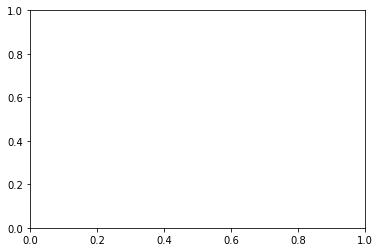

In [12]:
# some check and stats
def check_aid(aid):
    res = np.load(os.path.join(RAWDIR, 'adm-{0}.npy'.format(str('%.6d' % aid))), allow_pickle=True).tolist()
    mortal, die24, die24_48, die48_72, die30days, die1year = res['adm_labels']
    admfs = res['adm_features']
    admlb = res['adm_labels']
    try:
        assert (((~(die24 | die24_48 | die48_72)) | die30days) & 1) == 1
        assert (((~(die24 | die24_48 | die48_72 | die30days)) | die1year) & 1) == 1
    except:
        print(admlb)
    return admfs, admlb, aid

admission_ids_17f_raw = [re.match(r'adm\-(\d+)\.npy', x) for x in os.listdir(RAWDIR)]
admission_ids_17f_raw = [int(x.group(1)) for x in admission_ids_17f_raw if x is not None]

p = Pool()
ress = p.map(check_aid, admission_ids_17f_raw)
ress = list(ress)

print('mortal:', np.sum([x[1][0] for x in ress]))
print('24hrs:', np.sum([x[1][1] for x in ress]))
print('24~48hrs:', np.sum([x[1][2] for x in ress]))
print('48~72hrs:', np.sum([x[1][3] for x in ress]))
print('<=30d:', np.sum([x[1][4] for x in ress]))
print('<=1yr:', np.sum([x[1][5] for x in ress]))

# age, type_of_admission, aids, metastatic_cancer, hematologic_malignancy
print('aids:', np.sum([x[0][2] for x in ress]))
print('metastatic_cancer:', np.sum([x[0][3] for x in ress]))
print('hematologic_malignancy:', np.sum([x[0][4] for x in ress]))

from collections import Counter

toc_counter = Counter([x[0][1] for x in ress])
plt.bar([0,1,2,3], [value for _, value in toc_counter.items()], 0.5)
plt.xticks(np.arange(4), [rev_mapping['admission_type_ms'][x] for x, _ in toc_counter.items() ])

x2 = [x[0][0]/365.25 for x in ress]
np.max(x2)

plt.hist([x[0][0]/365 for x in ress], 40)

## Select admissions with > xxhrs records

In this step we only keep admissions with record length > 24/48 hrs.

In [13]:
def extract_time_series(aidres):
    time_series = aidres['serial_features']
    tn = time_series['timestep']
    fn = time_series['features']
    codes = time_series['codes']
    series = [[None for ft in range(fn)] for tt in range(tn)]
    for tt, ft, value in codes:
        try:
            series[tt][ft] = value
        except:
            print(tt, ft, value, tn, fn)
    return series

def check_adm_hrs_pass(admres, hrs):
    return admres['serial_features']['timelength'] > hrs * 3600.0
    
def extract_data(aid, hrs):
    admres = np.load(os.path.join(RAWDIR, 'adm-%.6d.npy' % aid), allow_pickle=True).tolist()
    if check_adm_hrs_pass(admres, hrs):
        ori_admres = np.load(os.path.join(SOURCEDIR, 'adm-%.6d.npy' % aid), allow_pickle=True).tolist()
        return (
            extract_time_series(admres),
            ori_admres['icd9'],
            ori_admres['general'],
            admres['adm_features'],
            admres['adm_labels']
        )
    else:
        return None
        
def collect_admissions_with_more_than_hrs(hrs):
#     raw_aids = [re.match(r'adm\-(\d+)\.npy', x) for x in os.listdir(RAWDIR)]
#     raw_aids = [int(x.group(1)) for x in raw_aids if x is not None]
    
    processed_data_all = np.load(os.path.join(TARGETDIR, '%dhrs' % hrs, 'DB_merged_%dhrs.npy' % hrs), allow_pickle=True).tolist()
    processed_valid_aids = sorted([t[0][-1] for t in processed_data_all])
    
    HRDIR = os.path.join(TARGETDIR, '%dhrs_raw' % hrs)
    if not os.path.exists(HRDIR):
        os.makedirs(HRDIR)
        
    p = Pool()
    collec = [p.apply_async(extract_data, args=(aid, hrs)) for aid in processed_valid_aids]
    p.close()
    p.join()
    collec = [x.get() for x in collec]
    collec = [x for x in collec if x is not None]
    
    data_all = [r[0] for r in collec]
    label_icd9_all = [r[1] for r in collec]
#     label_mor_all = [r[2][:6] for r in collec]
    label_mor_all = [r[2] for r in collec]
    adm_features_all = [r[3] for r in collec]
    adm_labels_all = [r[4] for r in collec]
    
    np.save(os.path.join(HRDIR, 'DB_merged_%dhrs.npy' % hrs), data_all)
    np.save(os.path.join(HRDIR, 'ICD9-%dhrs.npy' % hrs), label_icd9_all)
    np.save(os.path.join(HRDIR, 'AGE_LOS_MORTALITY_%dhrs.npy' % hrs), label_mor_all)
    np.save(os.path.join(HRDIR, 'ADM_FEATURES_%dhrs.npy' % hrs), adm_features_all)
    np.save(os.path.join(HRDIR, 'ADM_LABELS_%dhrs.npy' % hrs), adm_labels_all)

# > 24hrs
collect_admissions_with_more_than_hrs(24)

/home/z003xbnv/miniconda2/envs/bk/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [14]:
collect_admissions_with_more_than_hrs(48)

In [15]:
admres = np.load(os.path.join(RAWDIR, 'adm-%.6d.npy' % 199999), allow_pickle=True).tolist()
admres['serial_features']['codes']

[(18, 5, 36.55555555555556),
 (37, 5, 36.388888888888886),
 (45, 5, 36.333333333333336),
 (51, 5, 38.333333333333336),
 (56, 5, 38.05555555555556),
 (60, 5, 37.22222222222222),
 (79, 5, 37.666666666666664),
 (85, 5, 38.166666666666664),
 (96, 5, 36.44444444444444),
 (105, 5, 37.0),
 (116, 5, 36.94444444444444),
 (124, 5, 36.55555555555556),
 (133, 5, 36.5),
 (137, 5, 37.22222222222222),
 (146, 5, 37.55555555555556),
 (159, 5, 37.27777777777778),
 (164, 5, 36.55555555555556),
 (179, 5, 36.833333333333336),
 (185, 5, 36.666666666666664),
 (190, 5, 36.333333333333336),
 (197, 5, 36.333333333333336),
 (206, 5, 36.333333333333336),
 (213, 5, 36.72222222222222),
 (47, 8, 300.0),
 (57, 8, 600.0),
 (61, 8, 400.0),
 (76, 8, 460.0),
 (86, 8, 50.0),
 (96, 8, 450.0),
 (97, 8, 450.0),
 (102, 8, 550.0),
 (107, 8, 400.0),
 (117, 8, 400.0),
 (126, 8, 100.0),
 (130, 8, 540.0),
 (134, 8, 150.0),
 (141, 8, 400.0),
 (145, 8, 300.0),
 (146, 8, 250.0),
 (159, 8, 300.0),
 (162, 8, 250.0),
 (172, 8, 350.0),
 